In [66]:
# NLP libraries
import en_core_web_sm # <- necessary for running spaCy (see below)
import nltk # <- most used and the most core NLP library
import re # <- regular expressions
import spacy # <- really convenient NLP library to do advanced stuff

from gensim.models.phrases import Phrases, Phraser # <- get common ngrams using the NLP library Gensim
from nltk import FreqDist # <- count words in a corpus
from nltk.corpus import stopwords # <- list of common English words like 'the'
from nltk.stem import PorterStemmer, WordNetLemmatizer # <- reduce words to their most basic form
from spacy import displacy # <- let's you visualizer spaCy 
from wordcloud import WordCloud # <- wordcloud visualizations for Matplotlib

# Basic data processing and visualization libraries
import matplotlib.pyplot as plt # <- most common data viz library
import numpy as np # <- basic dataframe operations
import pandas as pd # <- basic dataframe operations
import seaborn as sns # <- fancy data visualizations

# Core Python libraries
from collections import Counter # <- count things in lists
import warnings # <- used to suppress unnecessary warnings


# Intro and Load Data

This notebook offers a rough introduction to Natural Language Processing (NLP). We will work with New York City Airbnb data, collected and published by [InsideAirbnb](http://insideairbnb.com). The notebook is roughly divided into two parts. 

The first part introduces techniques for making text into the kind of data that can be easily visualized and fitted into statistical models. This includes tokenization, stopword removal, lemming/stemming and ngrams as well as wordcloud and word frequency visualizations. We also introduce spaCy, a very easy and convenient NLP library that gives us access to machine learning based functionality such as [Named Entity Recognition](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da).

The second part looks at how words can be made into data for statistical models and machine learning. We will see how the machine learning library Sklearn can be used to create matrices for counting word frequencies in a set of documents, how this representation can be improved using so called Tf-Idf vectors as well basic similarity measures for comparing different text documents. Finally, we will get a basic introduction to machine learning (ML) in general using linear regression and ML for NLP in particular using so called Naïve Bayes classification.

NLP is a very complex field that is hard to grasp in its entirety. Currently, the most fundamental book for the field of NLP is [**Speech and Language Processing**](https://web.stanford.edu/~jurafsky/slp3/) by Dan Jurafsky and James Martin. Large parts of the draft version of the 3rd edition can be found online for free, and is highly recommended reading for anyone interested in the field. If you are interested in the cool and terrifying things that can be done with NLP, I really recommend getting familiar with [Jurafsky's other academic work](https://web.stanford.edu/~jurafsky/) too.

Before we start, it is important to get a grasp of *what* we are doing and *why*. NLP is, in general, concerned with language models. An easy way to think about an language model, is to say that it is concerned with the likelihood of any given sequence of words, given knowledge of previous sequences of words.

Let's say we have access to all of the New York Times archive. This is the data that informs of how language works, what kind of sentences are common and so on. Now we can estimate how common any other sentence would be.

Think of two example sentences:

>1) I want to eat Chinese food

>2) I want to eat British food

Which sentence is more probable? Well, given our New York Times data it would probably be the first, because how often would someone have written in the paper about how fantastic British food is? One way we could quantify this guess, would be to simply count the times each word appears with the other words in the sentence, compared with how often each word appears in general.This would be written like this:

>P(I want to eat Chinese food) = P(I|{start}) P(want | I) P(to | want) P(eat | to) P(Chinese | eat) P(food | Chinese) P({end}|food)
    
>P(I want to eat British food) = P(I|{start}) P(want|I) P(to|want) P(eat|to) P(British|eat) P(food|British) P({end}|food)

Here 'P' stands for 'probability of whatever occurs in the parenthesis, so 'P(X)' would mean the probability of 'x'. P(X|Y) simply means 'the probability of X *given* that we know Y'. So the above example would simply  mean that we count how probable a word is given the previous word. 

The example is very general and you don't need to understand the details here. The general point to grasp is that in order to do NLP, we need to be able to count words and word sequences. To do this, we need to go through a whole set of tasks that are often called **preprocessing**. These make documents and sentences into lists of words, that we can start running computations on. 

The first part of this tutorial will show how to do different steps of this preprocessing. The second part shows how the preprocessed data can be used for simple machine learning. Let's start.

# PART 1: Basic NLP & Fun NLP with SpaCy

Let's begin with loading our data and getting an overview of it using 'shape' and 'head()'.

In [67]:
# Load the Airbnb dataset, same as for the GIS classes!
airbnb_data = pd.read_csv("../datasets/InsideAirbnb_NY_03May2019/listings_full.csv")

# Let's print the shape and get the first rows of some interesting columns
print(airbnb_data.shape)
airbnb_data[["name", "id", "listing_url", "description","host_name", 
             "host_about", "host_total_listings_count", "host_id", "neighbourhood"]].head()

(48941, 106)


name        id  \
0               High Floor apt.near Columbus Circle   1742654   
1                          Cozy East Village studio  23502842   
2                         Great Location by Subway!  15984984   
3  Beautiful Cozy Garden Apt- Historic Clinton Hill  13820083   
4                Cozy 1 Bedroom apartment fitting 4   6170979   

                             listing_url  \
0   https://www.airbnb.com/rooms/1742654   
1  https://www.airbnb.com/rooms/23502842   
2  https://www.airbnb.com/rooms/15984984   
3  https://www.airbnb.com/rooms/13820083   
4   https://www.airbnb.com/rooms/6170979   

                                         description  host_name  \
0  Deep in the heart of Manhattan, this Little To...        Jon   
1  Studio apartment on a quiet street.  Great nat...    Tiffany   
2  I have a very spacious apartment right next to...       Nilu   
3  Non Smoking. Close to Barclays Center, Peaches...    Maritza   
4  The Apartment is in a safe environment next to...  Alexander   

                                          host_about  \
0  Born and raised in South Texas, I have resided...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   host_total_listings_count   host_id   neighbourhood  
0                        1.0   9173924  Hell's Kitchen  
1                        1.0  34777741       Manhattan  
2                        3.0   9737900        Brooklyn  
3                        3.0  31829334        Brooklyn  
4                        1.0  31104121        Brooklyn

# 1.1 Preprocessing: Tokens and stopwords

NLP takes a lot of computing power. Let's use the Pandas "sample" function to get a small subset of the data. We set the same random_state for everyone so that we all work with the same data.

In [68]:
# Get random sample from data using Pandas "sample" function
airbnb_data = airbnb_data.sample(5000, random_state = 42)

# Shape, again.
airbnb_data.shape

(5000, 106)

There are some description rows with the value 'NULL'. These will cause trouble unless we fix them. Let's replace them with an empty string.

In [69]:
# Replace missing / NULL values with an empty string
airbnb_data['description'] = np.where(airbnb_data['description'].isnull(), 
                                      "", airbnb_data['description'])

This is the most important step in almost any NLP workflow! In order to actually work with language as data, we need to chop it up into pieces that can be compared between rows. We will **tokenize** the data, which means that we split it into a list of words. So we go from one long string to a list of words.

In [70]:
# Tokenization just means we split every sentence into a list of words. This is what this list comprehension does.
airbnb_data['description_tokenized'] = [d.split() 
                                        for d 
                                        in airbnb_data['description']]

# Let's again get the head.
airbnb_data[['description_tokenized']].head()

description_tokenized
13876  [Along, its, breathtaking, views, of, the, Har...
5466   [Clean,, comfortable, apartment, in, charming,...
5854   [This, is, the, 2nd, room, available, in, my, ...
12628  [Your, PRIVATE, 400, SQ, FT, CLEAN, &, QUIET, ...
5822   [This, lovely, Garden, Apartment, room, has, w...

Now that every desciption is split into a list of words, we can actually see what our **corpus** is. This means that we will extract every word from every description into a long effin list. Let's see what the first 20 words are in this list.

In [71]:
# All words into a list, again using list comprehensions
corpus = [token for tokens in airbnb_data['description_tokenized'] for token in tokens]

# Get first 20 items of list
corpus[1:20]

['its',
 'breathtaking',
 'views',
 'of',
 'the',
 'Harlem',
 'River,',
 'our',
 'Mott',
 'Haven',
 'apartment',
 'is',
 'surrounded',
 'by',
 'culture',
 'and',
 'authentic',
 'Latin',
 'American']

Okay, cool. But this is just one description. We want to get an overview of how words are distributed across all descriptions. So, let's get the unique tokens in our corpus. We can do this using set, which returns the unique values of a list, and then turn the set into a list of those unique values (sets are annoying to work with, that's why we make it into a list again. Let's print two values:
1. The total amount of words in our data
2. The amount of unique words (or tokens!) in our data

In [72]:
# Unique tokens in our data
unique_tokens = list(set(corpus))

# Print total amount of tokens vs unique tokens
print(len(corpus))
print(len(unique_tokens))

664777
38697


Yassss. This already tells us somethinh, but let's go even further and *count* all words in the data and see what the most common words are.

In [73]:
# Get word counts or frequencies using the builtin Python method 'Counter'
word_frequencies = Counter(corpus)

# Print the most common words using the Counter function 'most_common()'
word_frequencies.most_common(15)

[('and', 26837),
 ('the', 24126),
 ('a', 18243),
 ('to', 16009),
 ('is', 13144),
 ('in', 12640),
 ('of', 11016),
 ('with', 9126),
 ('The', 5968),
 ('for', 5807),
 ('you', 5303),
 ('apartment', 5086),
 ('from', 4938),
 ('are', 3940),
 ('on', 3839)]

Looking at the output, we might notice at least two things. One, these aren't very interesting words! Instead, what we got is just a list of the most common words in the English language, broadly speaking. This is a problem: we are using NLP to learn how to distinguish different types of text. These words are so numerous, that if we leave them in place we run the risk of getting just noise, no signal! 

Second, some words, like "the" appear twice: once all lower case, the second time with the first letter upper case. This happens because Python does not recognize the difference between upper and lower case.

This is issue is capture by **Zipf's Law**: "the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc.: the rank-frequency distribution is an inverse relation." ([Wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

What this means, is that if we don't deal with these common words somehow, many texts will seem artificially similar.

![Zipf's law](../img/zipfs_law.png)

These very common words are called **stop words**. In NLP, it's commonly considered best practice to get rid of stop words (although some people think it's unnecessary). Many NLP libraries have lists of stopwords, both in English and many other languages. Let's use one from NLTK, which is perhaps most common NLP library. Using print, and 'len()', we see that the list contains 153 stopwords, which include common pronouns and verbs.

In [74]:
# Length of NLTK stopwords list
print(len(stopwords.words("english")))

# First ten stopwords in NLTK
print(stopwords.words("english")[:10])

# Last ten stopwords in NLTK
print(stopwords.words("english")[-10:])

153
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']
['ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']


We will use the NLTK stopwords in a few loops, so let's save them into a variable. We will save them as a set, because they are (supposedly) faster to iterate than lists. 

In [75]:
# Get stopwords from NLTK and save them into a more succintly named variable
stop_words = set(stopwords.words("english"))

Okay, we now have our stopwords. The next step is to remove them from each description. Let's remember what the data structure here is: we (1) have a Pandas column with descriptions and (2) each description is a list of words. So we have a list of lists. One way to iterate through this structure is to use a for loop and then a second for loop in the first for loop (like in the cellular automata class). This is very slow, so let's run a list comprehension in the first for loop, as a compromise of sorts.

Before removing the stopwords, we also want to make sure we are just dealing with words and not numbers, for example. Again, common practice is NLP is to remove special characters (such as -, ! and ?) and numbers. We do this using [**regular expressions**](https://developers.google.com/edu/python/regular-expressions) or "regex". They are a simple but very powerful tool for matching text patterns. We won't go into them in detail, but just remember that they are a good way to extract and replace text. They are definitely part of the basic toolbox of NLP. You can use regex in Python by loadin the 're' library (like we do at the beginning of this codebook).

Once we start nesting loops and list comprehensions, our code will get slow. Efficiency becomes an issue, in short. So we will start to include some ["built-in iPython Magic"](https://ipython.readthedocs.io/en/stable/interactive/magics.html) commands to measure our performance. This is done by preceding commands with '%%'. In this case, we write '%%time' to get a read on how long executing our codeblock took, once it's done running. Another good practice is to include some code in your for-loop to show how fast it's running. This is why I include an if statement that will print a read for every 1000 rows in the for-loop.

In [76]:
%%time

## ONE BAD WAY

# Initialize an empty column to add filtered tokens to
airbnb_data['tokenized_slow'] = ''
counter = 0
for i, row in enumerate(airbnb_data['description']):
    # Remove all non-word characters from each description and substitute them with whitespace.
    only_words = re.sub('[^A-Za-z0-9]+', ' ', row.lower()).split()
    
    # Remove stopwords by running a list comprehension on every description.
    airbnb_data['tokenized_slow'][i] = [word for word in only_words
                                        if word not in stop_words]
    
    # Keep track of how long the loop has been running
    counter += 1
    if counter % 1000 == 0:
        print("Preprocessed " + str(counter) + " descriptions.")

# Print a final message to show we are done.
print("Preprocessed a total of " + str(counter) + " descriptions.")

Preprocessed 1000 descriptions.
Preprocessed 2000 descriptions.
Preprocessed 3000 descriptions.
Preprocessed 4000 descriptions.
Preprocessed 5000 descriptions.
Preprocessed a total of 5000 descriptions.
CPU times: user 13.5 s, sys: 2.12 s, total: 15.6 s
Wall time: 17.3 s


When I ran this, it took 12.3 seconds. That's not good, and it will get exponentially slower if we increase the amount of listings. A faster way of doing this, is to again use list comprehensions. However, we have a problem here: We want to return a list of lists. So we basically want to run list comprehensions on every row of the tokenized descriptions. This is why we used a for-loop, but that was slow. So what to do?

One approach, is to use the [**apply method**](http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/) for Pandas combined with an [**anonymous funcion**](https://en.wikipedia.org/wiki/Anonymous_function). Let's start with apply.

Apply takes a column from a dataframe and let's you run a function on every value in a column of the dataframe. Were we, for example, to write "airbnb_data['description'].apply(print)", we would print every value in the column, one by one. Not very useful for print, but very useful for other functions, that couldn't normally be applied to a whole column. 

Lambda functions let us define a function on the fly. Instead of formally writing a function, we can define it as we run it. So we can call 'lambda' on an output x and then run a list comprehension on that output. See the codeblock below for an example. If you want to learn more about anonymous functions, you should familiarize yourself with [lambda calculus](https://en.wikipedia.org/wiki/Lambda_calculus). The main takeaway is that we can define each row in "airbnb_data['description']" as an "x" that we can feed into a list comprehension, instead of looping through the column. You will see that this approach is much, much faster, even though it might see similar to the nested loops.

In [77]:
%%time

# Like above, use regex to keep only words
airbnb_data['tokenized'] = [re.sub('[^A-Za-z]+', ' ', words.lower()).split() 
                            for words in airbnb_data['description']]

# Then use apply together with a lambda function to remove every token that is in the stopwords 
# AND to get back a list of lists, instead of one long list.
airbnb_data['tokenized'] = airbnb_data['tokenized'].apply(lambda x: [t for t in x if t not in stop_words])

# Look at what you made
print(airbnb_data['tokenized'][:2])

13876    [along, breathtaking, views, harlem, river, mo...
5466     [clean, comfortable, apartment, charming, will...
Name: tokenized, dtype: object
CPU times: user 905 ms, sys: 93.5 ms, total: 998 ms
Wall time: 1.12 s


Using '%%time' again, we see that this produces the same result as the for-loop, but much, much faster.

# 1.2 Preprocessing: Lemming and Stemming

Now that we have cleaned our text data of special characters and numbers, as well as removed stopwords, let's get the corpus and unique tokens again. Let's also print the most common words, to see what they look like after we removed words like 'the' and 'in'. I will also get all words that start with 'rest' or 'apa', in order to prove a broader point about the corpus (see next markdown and code blocks). We then print the most common of the 'apa' and 'rest' words.

In [78]:
# Get corpus of tokens
corpus = [token for tokens in airbnb_data['tokenized'] for token in tokens]

# Get unique tokens in corpus
unique_tokens = list(set(corpus))

# Print length of corpus and unique tokens
print(len(corpus))
print(len(unique_tokens))

# Get most common words using the Python function 'Counter'
word_frequencies = Counter(corpus)

# Let's get the words that start with 'apa' or 'rest'
apa_words = [word for word in list(word_frequencies.keys()) if word.startswith(('rest', 'apa'))]

# Call 'most_commont()' to filter down to the 1000 most common values
mostcommon1k = word_frequencies.most_common(1000)

# Print the words that start with 'apa' or 'rest' AND that are among the most common words
[print(mostcommon1k[i]) for i, word in enumerate(mostcommon1k) if mostcommon1k[i][0] in apa_words]


397617
12916
('apartment', 6951)
('restaurants', 2704)
('restaurant', 250)
('apartments', 172)
('rest', 164)


[None, None, None, None, None]

One conclusion to draw from this is, that it might be good if we could get words just in their basic form. What does this mean? It means that we want to get the [lemma](https://en.wikipedia.org/wiki/Lemma_(morphology)) or the [stem](https://en.wikipedia.org/wiki/Word_stem) of each word. A lemma is the citation or dictionary form of a word. It is the form a word is written in, when we try to define it. So 'restaurants' would be simply 'restaurant'. A stem, on the other hand, is such a version of a word to which affixes (suffixes, prefixes) can be attached. This means that the word is cut down to such a form, that all possible extensions of it can be written by just adding letters to this basic form. So 'breathtaking' would have to be 'breathtak' because we need to be able to extend it to both 'breathtaking' and 'breathtaken' (and many other forms).

I prefer lemmas, because stems can sometimes look pretty weird. A good library for finding the lemma or stem of a word, is NLTK. We will here run the WordNet lemmatizer, which extracts lemmas based on the vast corpus of lemmas collected in the [WordNet library](https://wordnet.princeton.edu/) at Princeton University. For stemming, we use the Porter stemmer, which is a pretty standard choice for stemming.

In [79]:
%%time

# Initalize the Wordnet Lemmatizer
nltk_lemmatizer = WordNetLemmatizer()

# Run the WordNet Lemmatizer on all descriptions using apply and a lambda function
airbnb_data['nltk_lemmas'] = airbnb_data['tokenized'].apply(lambda x: 
                                                            [nltk_lemmatizer.lemmatize(t) for t in x])

# Print the first five lemmatized descriptions
print(airbnb_data['nltk_lemmas'][:5])

13876    [along, breathtaking, view, harlem, river, mot...
5466     [clean, comfortable, apartment, charming, will...
5854     [nd, room, available, home, bunk, bed, twin, s...
12628    [private, sq, ft, clean, quiet, apt, ues, manh...
5822     [lovely, garden, apartment, room, wonderful, n...
Name: nltk_lemmas, dtype: object
CPU times: user 3.24 s, sys: 77.8 ms, total: 3.32 s
Wall time: 3.64 s


In [80]:
%%time

# Initalize the Porter Stemmer
nltk_stemmer = PorterStemmer()

# Run the Porter Stemmer on all descriptions using apply and a lambda function
airbnb_data['nltk_stems'] = airbnb_data['tokenized'].apply(lambda x: 
                                                            [nltk_stemmer.stem(t) for t in x])

# Print the first five stemmed descriptions
print(airbnb_data['nltk_stems'][:5])

13876    [along, breathtak, view, harlem, river, mott, ...
5466     [clean, comfort, apart, charm, williamsburg, b...
5854     [nd, room, avail, home, bunk, bed, twin, size,...
12628    [privat, sq, ft, clean, quiet, apt, ue, manhat...
5822     [love, garden, apart, room, wonder, natur, lig...
Name: nltk_stems, dtype: object
CPU times: user 14.8 s, sys: 132 ms, total: 14.9 s
Wall time: 16 s


Having run the stemmer and the lemmatizer, we see that not only does lemmatizing procude more intuitive sets of words, but it's also faster! We'll dump the stems and just stick with the lemmas. Let's look at our corpus after we did this, running again the same set of functions we used earlier to get the corpus and unique token count.

In [81]:
# Let's get the corpus again
corpus = [token for tokens in airbnb_data['nltk_lemmas'] for token in tokens]

# Let's get the unique tokens in the corpus again
unique_tokens = list(set(corpus))

# Print the length of the corpus and unique tokens this time around
print(len(corpus))
print(len(unique_tokens))

# List the most common tokens
word_frequencies = Counter(corpus)
word_frequencies.most_common(10)

397617
11513


[('apartment', 7123),
 ('room', 6199),
 ('bedroom', 4857),
 ('kitchen', 4196),
 ('bed', 3334),
 ('train', 3299),
 ('block', 2963),
 ('restaurant', 2954),
 ('minute', 2952),
 ('living', 2804)]

We see that the corpus is slightly smaller, as duplicates such as 'restaurant' and 'restaurants' have been merged into the same lemmas. Next, let's look at the different frequencies of words in our corpus. What we want to know is basically how many words appear once, how many appear twice etc up to the most common word. Let's get a list of all the counts of counts and print the first then values.

In [82]:
word_frequency_counts = [value for value in word_frequencies.values()]
print(list(word_frequencies)[:10])
print(word_frequency_counts[1:10])

['along', 'breathtaking', 'view', 'harlem', 'river', 'mott', 'apartment', 'surrounded', 'culture', 'authentic']
[39, 957, 315, 378, 11, 7123, 168, 127, 89]


The above output first gives us ten words, then their frequencies, in two separate lists. Now we want to count the count of counts. Let's make the counts into a Series and print the biggest count (see below). Turns out it's the count for apartment.

In [83]:
count_of_counts = pd.Series(word_frequency_counts)
max(count_of_counts)

7123

Let's visualize these values, to make it more intuitive.

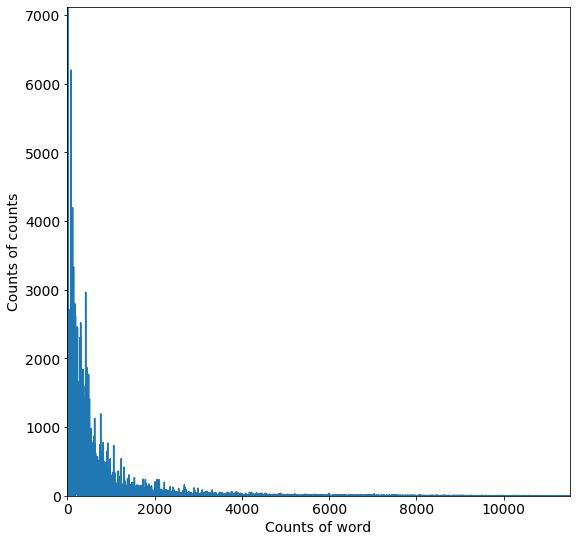

In [84]:
count_of_counts.plot(figsize = (9,9))

axes = plt.gca()
axes.set_ylim([0,max(count_of_counts)])
plt.xlabel("Counts of word", size = 14)
plt.ylabel("Counts of counts", size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

Looking at the plot, we see that most words appear only a very few times and that many words appear only once. Because we are analysing data to find commonalities between descriptions, these words are more or less useful for us. So we can throw away any word that appears only once (we could, in fact, probably throw away anything that appears less than 10 times). We do it using the list comprehension below. It checks that a word appears more than once and saves only those words. It doesn't (yet) remove the words from the tokenized descriptions, but gives us a corpus of all words that appear more than once. We will later use this dataset for our machine learning models. 

In [85]:
%%time

unique_tokens_less_sparse = [tple[0] for tple in word_frequencies.most_common() if tple[1] > 1]
print(unique_tokens_less_sparse[:10])
print(len(unique_tokens_less_sparse))
print(len(unique_tokens))

['apartment', 'room', 'bedroom', 'kitchen', 'bed', 'train', 'block', 'restaurant', 'minute', 'living']
6603
11513
CPU times: user 9.25 ms, sys: 294 µs, total: 9.54 ms
Wall time: 9.39 ms


# 1.3 Wordclouds and frequency visualizations

A classical and popular way of visualizing word frequencies in a corpus is **wordclouds**. Python has a package called 'WordCloud', which makes it very easy to produce these visualizations. Let's try it with the list of words that appear more than once

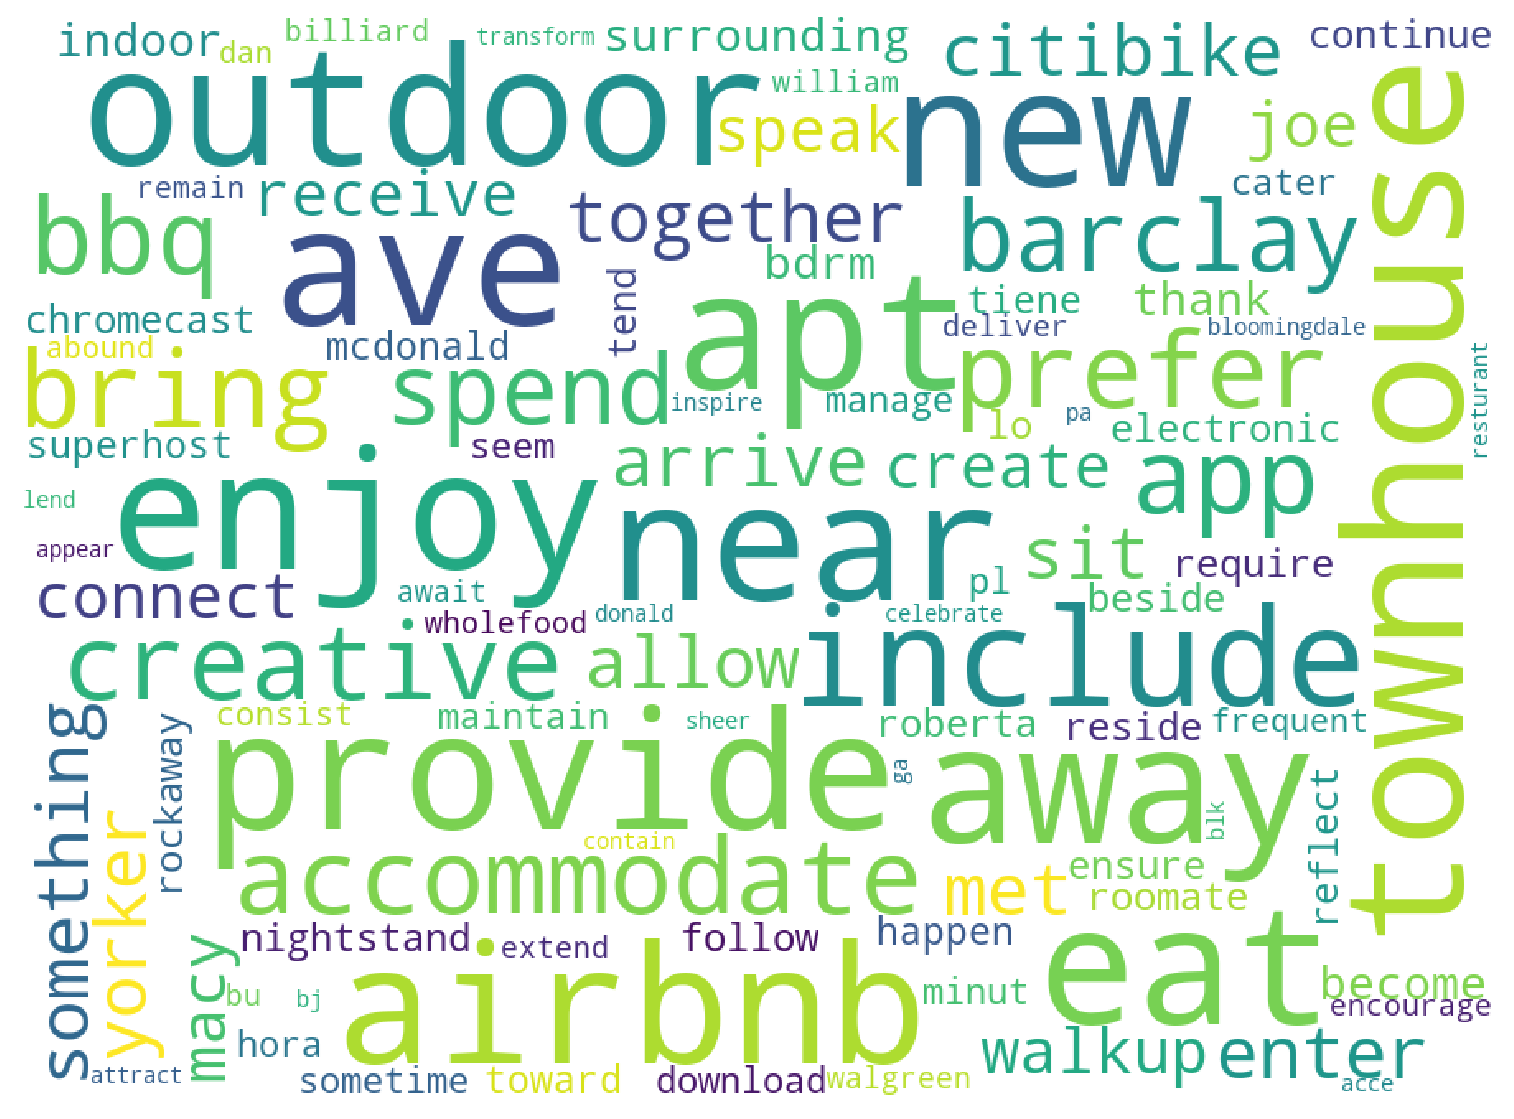

In [86]:
# WordCloud doesn't take tokens, but full sentences. So let's join our tokens into strings.
corpus_as_string = ' '.join(unique_tokens_less_sparse)

# We call WordCloud and set some parameters.
#   1. We don't want all words, so let's set max_words equal to 100
#   2. Let's set a high value for width and height, in order to get a high resolution on our cloud
#   3. Then we '.generate()' in order to make it
wordcloud = WordCloud(background_color='white',
                      max_font_size=100, max_words=100,
                      width=900, height=660,
                      collocations = False).generate(corpus_as_string)

# Good ol' MatplotLib
plt.figure(figsize=(12, 9), 
           dpi=160, 
           facecolor='w')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For more on generating wordclouds in Python, you can checkout [this neat article](https://www.datacamp.com/community/tutorials/wordcloud-python) at DataCamp. Personally, I don't like wordclouds that much. They offer a good overview, sure, but they don't really give an accurate picture of *how* common words actually are. Let's try to user Seaborn to actually visualize the counts of the most common words in our corpus.

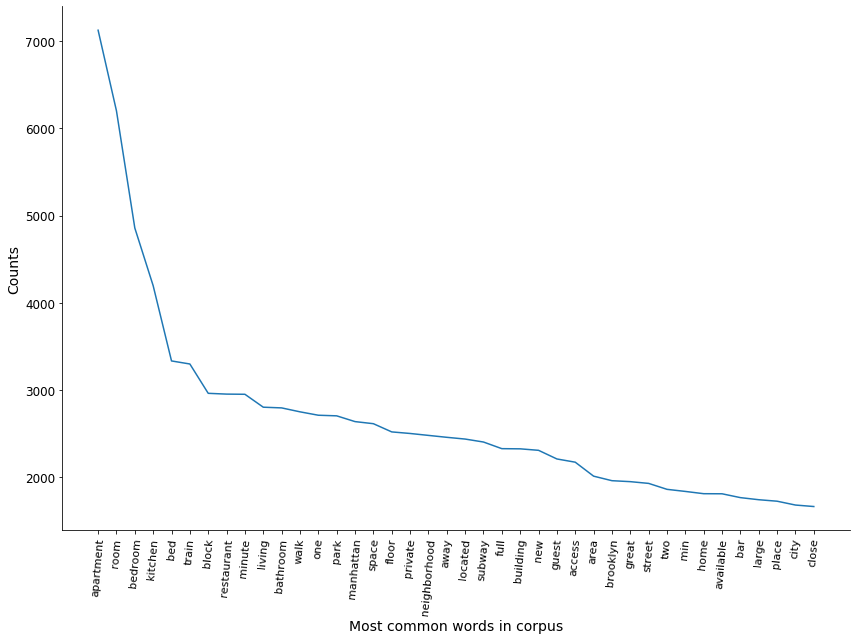

In [87]:
all_counts = FreqDist(corpus)
most_common_counts = list(zip(*all_counts.most_common(40)))

fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
lines = sns.lineplot(list(range(0,len(most_common_counts[0]))), 
                     most_common_counts[1])
sns.despine()
plt.xlabel(xlabel='Most common words in corpus', fontsize=14)
plt.ylabel(ylabel='Counts', fontsize=14)
plt.xticks(ticks = list(range(0,len(most_common_counts[0]))), rotation=85, fontsize=11)
ax.set_xticklabels(most_common_counts[0])
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 1.4 Ngrams and Phrases

One glaring issue in everything we have done so far, is that all of our tokens are individual words. This means that we fail to capture phrases and expressions like 'New York City' or 'queen sized bed' – both of which are very common in the Airbnb dataset. A solution to this problem is to add so called ngrams to our tokens. An ngram is "a contiguous sequence of n items from a given sample of text or speech" ([Wikipedia](https://en.wikipedia.org/wiki/Word_stem)). The unigrams of our corpus are just the tokens. The bigrams are all sequences of two words that appear after each other. A trigram are all sequences of three words that appear after each other and so on. You can use the list comprehension below to get all the unigrams in the lemmas of the descriptions that we created earlier.

In [88]:
# Let's try getting bigrams by juts running it on one sentence. Let's select that sentence.
first_description_words = airbnb_data['nltk_lemmas'].iloc[1]

# Now let's use list comps to get the bigrams in that sentence, join them by '_' and print the first 15 of them
bigrams = ["_".join(first_description_words[i:i+2]) for i in range(len(first_description_words)-2+1)]
bigrams[:15]

['clean_comfortable',
 'comfortable_apartment',
 'apartment_charming',
 'charming_williamsburg',
 'williamsburg_brooklyn',
 'brooklyn_young',
 'young_artsy',
 'artsy_neighborhood',
 'neighborhood_near',
 'near_park',
 'park_shop',
 'shop_deli',
 'deli_cafe',
 'cafe_restaurant',
 'restaurant_bakery']

We can create trigrams by just chaning the '2' in the previous list comprehension to a '3'. Like this:

In [89]:
trigrams = ["_".join(first_description_words[i:i+3]) for i in range(len(first_description_words)-3+1)]
trigrams[:5]

['clean_comfortable_apartment',
 'comfortable_apartment_charming',
 'apartment_charming_williamsburg',
 'charming_williamsburg_brooklyn',
 'williamsburg_brooklyn_young']

Instead of keeping chaning the 'n' of our list comprehension, let's make a function. This function now convers a list of words to the ngrams. Here we get the "five-grams". It's just an example: In practice we usually only want the uni, bi and trigrams.

In [90]:
# Create a new function to create ngrams of any length
def words_to_ngrams(words, n):
    ngrams = ["_".join(words[i:i+n]) for i in range(len(words)-n+1)]
    return(ngrams)

# Let's get five-grams, just for the heck of it
fivegrams = words_to_ngrams(first_description_words, 5)
fivegrams[:5]

['clean_comfortable_apartment_charming_williamsburg',
 'comfortable_apartment_charming_williamsburg_brooklyn',
 'apartment_charming_williamsburg_brooklyn_young',
 'charming_williamsburg_brooklyn_young_artsy',
 'williamsburg_brooklyn_young_artsy_neighborhood']

Now let's use our 'words_to_ngrams' function to get all the bigrams in the data. Let's print these bigrams.

In [91]:
%%time

# Let's run our function in a list comprehension, to get the bigrams of each document
bigrams = [words_to_ngrams(nhood, 2) 
           for nhood 
           in airbnb_data['nltk_lemmas']]

# Let's get the bigrams in one long list, so we can count them
# This is effectively our corpus as bigrams.
bigram_corpus = [token for tokens in bigrams for token in tokens]

# Use Counter to save and then print the 100 most common bigrams
common_bigrams = Counter(bigram_corpus).most_common(100)
print(common_bigrams)

[('living_room', 2050), ('new_york', 1067), ('minute_walk', 1023), ('block_away', 970), ('size_bed', 920), ('walking_distance', 906), ('bedroom_apartment', 802), ('central_park', 791), ('restaurant_bar', 672), ('time_square', 647), ('queen_size', 628), ('min_walk', 607), ('one_bedroom', 506), ('fully_equipped', 503), ('apartment_located', 485), ('washer_dryer', 477), ('kitchen_bathroom', 468), ('l_train', 449), ('subway_line', 449), ('full_size', 445), ('bar_restaurant', 443), ('private_room', 426), ('brand_new', 403), ('east_side', 399), ('private_bedroom', 379), ('york_city', 372), ('one_block', 362), ('full_kitchen', 361), ('fully_furnished', 361), ('prospect_park', 361), ('east_village', 357), ('newly_renovated', 354), ('coffee_shop', 352), ('high_ceiling', 348), ('queen_bed', 348), ('room_kitchen', 346), ('equipped_kitchen', 345), ('guest_access', 333), ('entire_apartment', 330), ('minute_away', 322), ('kitchen_living', 318), ('sized_bed', 317), ('subway_station', 316), ('two_bedr

Looks legit and the code runs fast! Let's do the same for trigrams.

In [92]:
%%time

# Let's run our function in a list comprehension, to get the trigrams of each document
trigrams = [words_to_ngrams(nhood, 3) 
           for nhood 
           in airbnb_data['nltk_lemmas']]

# Let's get the trigrams in one long list, so we can count them
# This is effectively our corpus as trigrams.
trigram_corpus = [token for tokens in trigrams for token in tokens]

# Use Counter to save and then print the 100 most common bigrams
common_trigrams = Counter(trigram_corpus).most_common(50)
print(common_trigrams)

[('queen_size_bed', 501), ('new_york_city', 372), ('fully_equipped_kitchen', 301), ('full_size_bed', 291), ('living_room_kitchen', 280), ('kitchen_living_room', 256), ('within_walking_distance', 241), ('lower_east_side', 218), ('queen_sized_bed', 210), ('one_bedroom_apartment', 184), ('couple_solo_adventurer', 175), ('solo_adventurer_business', 161), ('empire_state_building', 157), ('upper_east_side', 157), ('adventurer_business_traveler', 156), ('one_block_away', 156), ('flat_screen_tv', 147), ('good_couple_solo', 147), ('bedroom_queen_size', 135), ('place_good_couple', 133), ('tree_lined_street', 132), ('upper_west_side', 127), ('stainless_steel_appliance', 125), ('high_speed_internet', 117), ('two_bedroom_apartment', 114), ('living_room_dining', 112), ('room_kitchen_bathroom', 111), ('bed_living_room', 108), ('access_entire_apartment', 102), ('bedroom_living_room', 99), ('two_block_away', 94), ('bathroom_living_room', 94), ('major_subway_line', 91), ('train_minute_walk', 90), ('livi

Still looking good! However, there is a problem. We usually don't want *all* of the trigrams and bigrams. Rather, we want some of the most bigrams and trigrams to replace unigrams that don't make that much sense alone. So we wan't the tokens 'new', 'york' and 'city' to simply be 'new_york_city'. After that we don't want the unigrams 'new', 'york' and 'city' anymore. 

This process is called 'phrasing', as the idea is to find common phrases in the data. We could write some complex function to do this, but there is a really good NLP library that can do it for us. It's called "Gensim" and it contains all kinds of convenient functions for preparing text data for NLP analysis and many basic machine learning models that you can run in a few lines.

In Gensim, we are specifcially interested in the functions 'Phrases', which finds word pairs in the data and scores them based on how common they are. This is based on a formula from a [famous NLP paper](https://arxiv.org/abs/1310.4546) by researchers at Google. Basically, the algorithm compares the times words appear together (the nominator) subtracted by a penalty value (the squigly character in the formula) with the times they appear individually (the denominator).

![Phrasing Mikolov](../img/phrases_Gensim_Mikolov.png)

Let's try running this using Gensim. The way this works is, that we first filter for bigrams using Phrases. We then use these bigrams to get any bigrams of bigrams and unigrams (effectively trigrams!) to get the trigrams. We define a 'min_count', so that both will cutoff any bi or trigrams that appear less than 50 times in the data.

In [93]:
%%capture --no-stdout
%%time

# Let's define functions to get bigrams and trigrams 
bigram = Phrases(airbnb_data['nltk_lemmas'], min_count=50) # higher threshold fewer phrases.
trigram = Phrases(bigram[airbnb_data['nltk_lemmas']])  

# 'Phraser' is a wrapper that makes 'Phrases' run faster
bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)


CPU times: user 11.5 s, sys: 134 ms, total: 11.6 s
Wall time: 12.2 s


In [94]:
%%time

# DOING WITHOUT LIST COMPREHENSION
ngrammed = []
for description in airbnb_data['nltk_lemmas']:
    bigrams_ = [b for b in bigram[description]]
    trigrams_ = [t for t in trigram[bigram[description]]]
    ngrammed.append(trigrams_)
airbnb_data['lemmas_w_ngrams'] = ngrammed


CPU times: user 7.3 s, sys: 68.1 ms, total: 7.37 s
Wall time: 7.58 s


Let's print the output of our new tokens *with* ngrams. Looks pretty legit!

In [95]:
%%time

# This is a nested list comprehensions. We basically run list comprehension on the output of
# another list comprehensions. We first get bigrams and then get trigrams based on the bigrams.
airbnb_data['lemmas_w_ngrams'] = [t for t in trigram[[b for b in bigram[airbnb_data['nltk_lemmas']]]]]

# Print first 10 values of our output to see thsat what we created makes sense
print(airbnb_data['lemmas_w_ngrams'][:10])

13876    [along, breathtaking_view, harlem, river, mott...
5466     [clean, comfortable, apartment, charming, will...
5854     [nd, room, available, home, bunk_bed, twin_siz...
12628    [private, sq_ft, clean, quiet, apt, ues, manha...
5822     [lovely, garden, apartment, room, wonderful, n...
21011    [high_ceiling_exposed_brick, apartment, recent...
5158     [hi, everyone, renting, room, large, cosy, app...
40684    [hello, traveler, staying, space, queen_sized_...
23264    [great, neighbourhood, perfect, short_term, stay]
2975     [simply, charming, bedroom, duplex, located, l...
Name: lemmas_w_ngrams, dtype: object
CPU times: user 4.77 s, sys: 85.4 ms, total: 4.85 s
Wall time: 5.02 s


# 1.5 SpaCy: NLP Made Fun and Easy

All of this playing around with list comprehensions and for-loops is good to know if you want to use NLP, but in practice something of an overkill if you just want to access basic NLP functions. To avoid all this hasle, we can just rely on some good NLP libraries to do the groundwork. We had a taste of this when using NLTK and Gensim, now let's explore some even more advanced functions that show what NLP can do. For this, we will rely on the library 'spaCy'. One of the coolest properties of spaCy is that you can easily run basic machine learning for NLP. We can, for instance, get the sentiment of each document in our corpus or extract so called 'Named Entities' like 'Manhattan', 'Hillary Clinton' and 'Netflix'. 

Let's extract the following information from our text data, using spaCy:

1. [Parts-of-speech](https://en.wikipedia.org/wiki/Part_of_speech)
2. [Document dependency structure](https://en.wikipedia.org/wiki/Dependency_grammar)
3. [Named Entities](https://en.wikipedia.org/wiki/Named-entity_recognition)

The first step when using spaCy, is to load a model for a specific language. The reason why spaCy can be used without training crazy new machine learning models, is that the library offers pretrained models that have been developed using large datasets in several different langauge. To access the models for a specific langauge, we need to load them. [In the case of English](https://spacy.io/models/en), this happens running 'en_core_web_sm.load()' and saving it to a variable. We call it 'nlp', for the sake of simplicity. Now we can feed every document in our data to this nlp object and have it output all the cool shit we talked about above. Let's do this in a list comprehension.

In [96]:
%%time

# Load the cre English language models of spaCy
# For more details, see: https://spacy.io/models/en
nlp = en_core_web_sm.load()

# Let's rename our data, so that we don't have to drag the spaCy stuff along later
# when we move on to machine learning.
airbnb_data_slice = airbnb_data

# Let's run 'nlp' on every document in our data, using list comprehension
airbnb_data_slice['spacy_docs'] = [nlp(d) for d in airbnb_data_slice['description']]

CPU times: user 3min 13s, sys: 3.47 s, total: 3min 17s
Wall time: 3min 29s


When we run 'nlp()' on a document, spaCy basically fits its pretrained models on that document, extracting many essential NLP outputs. This is why running the function takes a couple of minutes, even on our relatively small dataset. Now we can move on to the different functionalities offered by spaCy.

### 1.5.1. Parts-of-speech using spaCy

Part-of-speech tagging means associating every token with a particular part-of-speech (POS). This is a tricky task in NLP, but spaCy has pretrained models that do a decent job on it. Why do we need POS tags? Because they provide additional information about the linguistic structure of our data, which in turn lets us improve the results of more advanced models, like Named Entitity Recognizers.

In [97]:
# Get the tokens and POS tags of each document, 
# using spaCy, the Pandas function 'apply' and a lambda function

parts_of_speech = airbnb_data_slice['spacy_docs'].apply(lambda x: 
                                                        [(token, token.pos_) for token in x])
# Print the tokens and POS tags of the first documents
[print(tokens) for tokens in parts_of_speech[:1]]

[(Along, 'ADP'), (its, 'DET'), (breathtaking, 'ADJ'), (views, 'NOUN'), (of, 'ADP'), (the, 'DET'), (Harlem, 'PROPN'), (River, 'PROPN'), (,, 'PUNCT'), (our, 'DET'), (Mott, 'PROPN'), (Haven, 'PROPN'), (apartment, 'NOUN'), (is, 'VERB'), (surrounded, 'VERB'), (by, 'ADP'), (culture, 'NOUN'), (and, 'CCONJ'), (authentic, 'ADJ'), (Latin, 'ADJ'), (American, 'ADJ'), (cuisine, 'NOUN'), (., 'PUNCT'), (This, 'DET'), (private, 'ADJ'), (bedroom, 'NOUN'), (is, 'VERB'), (in, 'ADP'), (a, 'DET'), (3, 'NUM'), (bedroom, 'NOUN'), (co, 'ADJ'), (-, 'ADJ'), (living, 'VERB'), (apartment, 'NOUN'), (., 'PUNCT'), (It, 'PRON'), (’s, 'PROPN'), (luxury, 'NOUN'), (building, 'NOUN'), (is, 'VERB'), (packed, 'VERB'), (with, 'ADP'), (amenities, 'NOUN'), (and, 'CCONJ'), (is, 'VERB'), (striding, 'VERB'), (within, 'ADP'), (its, 'DET'), (progressive, 'ADJ'), (neighborhood, 'NOUN'), (of, 'ADP'), (Bruckner, 'PROPN'), (Blvd, 'PROPN'), (., 'PUNCT'), (Along, 'ADP'), (its, 'DET'), (modern, 'ADJ'), (design, 'NOUN'), (,, 'PUNCT'), (ma

[None]

### 1.5.2. Dependency parsing using spaCy

Another important feature of language, is that sentences have a *hierarchy*. Moving up and down in the hierachy let's us understand how words are related to each other. Depending on where in a sentence and its hierarchy a word is, it's meaning can change. One approach for getting these structures is known as dependency parsing. It's a tricky NLP task, that spaCy, again, does this for us. Here we use a fun tool of spaCy, 'displaCy', to visualize these hierarchies.

In [98]:
# Use the spaCy related package displaCy to visualize sentence dependencies

displacy.render(airbnb_data_slice['spacy_docs'][4], 
                style="dep", 
                options = {"compact":False})

### 1.5.3. Named Entitity Recognition using spaCy

Okay, now for the really interesting part. Using some of the tools we described above, we can extract more complex information. Let's now get the named entities from our documents. This means that we can get lists of persons, grups, organizations, locations and so on. These are all 'named entities' because they are not just parts-of-speech but actual entities. The list below shows what kind of entities we can get using spaCy:

![Spacy Entities](../img/spacy_entity_types.png)

Getting the named entities using spacy is pretty easy. We need to get the 'ents' for each document. We can use list comprehensions and save these into a list of lists, where every sublist contains the text and NEW label of each document. Then we can use another list comprehensions to iterate through each sublist and get the named entities and it's label. Finally, we can use the Counter function from Python to get a list of the most common values. Many are a bit weird: Bushwick is interpreted as a person, for example. But many are accurate and even if the labels are off, it seems like most NERs are actually captured.

In [99]:
# Get all named entities
entities = [(doc.ents) for doc in airbnb_data_slice['spacy_docs']]

# Get the text and label of each entity
ner_labels = [(ent.text, ent.label_) 
              for sublist 
              in entities 
              for ent 
              in sublist 
              if ent.label_ not in ['CARDINAL', 'ORDINAL']]

# Get the counts of the most common entities
Counter(ner_labels).most_common(50)

[(('Manhattan', 'GPE'), 2268),
 (('Brooklyn', 'GPE'), 1302),
 (('NYC', 'ORG'), 641),
 (('Central Park', 'LOC'), 631),
 (('Williamsburg', 'GPE'), 540),
 (('New York', 'GPE'), 529),
 (('Times Square', 'FAC'), 399),
 (('NYC', 'GPE'), 392),
 (('New York City', 'GPE'), 295),
 (('Bushwick', 'PERSON'), 280),
 (('Airbnb', 'GPE'), 258),
 (('Union Square', 'FAC'), 198),
 (('AC', 'ORG'), 176),
 (('10 minutes', 'TIME'), 171),
 (('5 minute', 'TIME'), 169),
 (('JFK', 'PERSON'), 167),
 (('Prospect Park', 'LOC'), 165),
 (('10 minute', 'TIME'), 160),
 (('Broadway', 'FAC'), 160),
 (('15 minutes', 'TIME'), 152),
 (('East Village', 'GPE'), 150),
 (('20 minutes', 'TIME'), 133),
 (('Guest', 'PERSON'), 132),
 (('5 minutes', 'TIME'), 125),
 (('minutes', 'TIME'), 116),
 (('the day', 'DATE'), 116),
 (('Netflix', 'ORG'), 111),
 (('Astoria', 'GPE'), 110),
 (('Columbia University', 'ORG'), 106),
 (('night', 'TIME'), 105),
 (('West Village', 'GPE'), 102),
 (('15 minute', 'TIME'), 99),
 (('Apple TV', 'ORG'), 94),
 (

Okay, so a final cool tool that comes with spaCy and displaCy, is a visualizer for named entities. We can actually visualize the named entities that were identified in each document! This let's us evaluate how well the NER works. We will notice, that it's far from perfecst. NER is a difficult task and the documents we provided are short, often full of grammatical errors or otherwise incorrect English. How well a pretrained NLP algorithm performs on our data, depends on what the data it was originally trained on looks like. So if the data that spaCy used to train their NER is very different from ours, it will perform poorly.

One takeaway from this is, that NLP tasks are always idiosyncratic: We need to train our models on data that is similar to the data we are trying to classify.

In [100]:
# Run displacy.render and set style to "ent" to get the named entities of each document highlighted
displacy.render(airbnb_data_slice['spacy_docs'][:5], 
                style="ent")

# PART 2: Very Basic ML for NLP

Remember how we wrote at the top of this document, that the fundamental idea of NLP is that we can extract patterns of information from language and process it as data? To do so, we have to represent our document as a dataframe, where the columns represent features of he document. What these features look like depend on what we want to do. 

By completing the preprocessing steps we took before our detour into spaCy, we've transformed our data into a form where we can use it for a basic language model. Each document will be a row in our data and each token (whether uni, bi or trigram) will be a column or a **feature**. 

The most basic approach to look at this representation of our data, is to use the so called **bag-of-words** model. In this model, we simply count the occurence of words in a document and compare documents by these counts. In this way, every word is a column that says something about a document. Consequently, we will also get very, very large dataframes if we look at many documents. A corpus of 40,000 words will mean that we get 40,000 columns. 

This kind of dataframe is called a **document-term matrix**, because every row is a document and every column a term. The matrix is sparse, which means every row mostly consists of zeros. Why is this? Well, because most words occur only in a few documents.

As we saw above, there are other ways to describe a document. If we add parts-of-speech and named entities, we can make our features more descriptive. With parts-of-speech, a column could – for instance – be named by the word (or actually lemma) and the associated POS. This way, a word could appear twice if it is associated with two parts-of-speech (or more, if it is even more ambigious). 

Even more complex models incorporate more information. More elaborate models capture not just the count of words, but their ordering. These kinds of models model the words as sequences. They are for the most part quite complex, and we will not go into them. If you want to look into these types of models, you can familiarize yourself with [Hidden Markov Models](https://en.wikipedia.org/wiki/Hidden_Markov_model), [Embedding Models](https://www.quora.com/What-is-word-embedding-in-deep-learning) like [Word2Vec](https://www.tensorflow.org/tutorials/representation/word2vec) or [long-short term memory (LSTM) deep neural networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Let's start by importing some additional libraries. We are going to use sklearn, which is by far the most established Python library for running basic machine learning. It is a good starting point, because it contains all the most common ML algorithms, different functions to prepare your data as well as to analyse your results. If you ever decide to actually implement ML on a serious problem, it's a good idea to code your algorithms yourself or use some more serious ML libraries instead. But, for now, sklearn fits our needs perfectly.

In [101]:
from sklearn import metrics # <- this helps us interpret our results

from sklearn.cross_validation import train_test_split # <- we use this to prepare our data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # <- make words into numbers 
                                                                             #     you can compute on
from sklearn.linear_model import LinearRegression # <- this is the most basic model for stats and ML
from sklearn.metrics.pairwise import cosine_similarity # <- compare texts by their similarity
from sklearn.metrics import roc_auc_score # <- metrid to see how well we do on classification
from sklearn.naive_bayes import GaussianNB, MultinomialNB # <- this is a very simple model to classify stuff

# 2.1. Text as Data

Once we have loaded sklearn, it is time to prepare our corpus. Remember how we got lemmas using NLTK and phrases using Gensim? We saved this data in the column 'lemmas_w_ngrams'. Let's get the tokens from that column and print the length of the entire corpus as well as all unique tokens. 

Maybe you also remember, that we removed some words that occured only once? Let's now run a similar list comprehension to remove all ngrams that occur only once and then print the result.

In [102]:
%%time

ngram_corpus = [token for tokens in airbnb_data['lemmas_w_ngrams'] for token in tokens]
unique_ngrams = list(set(ngram_corpus))
print(len(ngram_corpus))
print(len(unique_ngrams))

ngram_frequencies = Counter(ngram_corpus)
ngram_frequencies.most_common(10)

ngrams_to_remove = [tple[0] for tple in ngram_frequencies.most_common() if tple[1] == 1]
unique_ngrams_less_sparse = [tple[0] for tple in ngram_frequencies.most_common() if tple[1] > 1]
print(unique_ngrams_less_sparse[:12])

316687
14152
['apartment', 'bedroom', 'room', 'kitchen', 'bathroom', 'one', 'private', 'space', 'manhattan', 'neighborhood', 'great', 'living_room']
CPU times: user 219 ms, sys: 15.9 ms, total: 235 ms
Wall time: 261 ms


Looks good. We are going to need our dataframe index many times, so let's name it in order to make it easier to call throughout the notebook.

In [103]:
airbnb_data = airbnb_data.set_index('id')

Okay, this step is important. We are going to **vectorize** our corpus using the sklearn CountVectorizer(). What does this mean? Well, remember how we said that we want our documents in the form of a **document-term matrix**? We basically want each row to be a document and each column to be a word. Then we want to know how many times a word appears in a document.

We could do this manually, but we will instead CountVectorizer() to do it automatically. We basically first initialize CountVectorizer() and tell it to only consider tokens that are in our 'unique_ngrams_less_sparse' list. We then **fit** this initialized model for how to vectorize the data using the function fit_transform() on the vectorizer, with our documents as input. We then give this to a Pandas dataframe, which is our document-term matrix. Sounds difficult? I get that, but it is really just a bunch of somewhat obscure steps to produce a really simple output.

In [104]:
# CountVectorizer wants full strings, not lists of tokens, so we join our tokens by document
docs = [' '.join(tokens) for tokens in airbnb_data['nltk_lemmas']]

# Initialize the vectorizer and tell it to only consider certain words
vec = CountVectorizer(vocabulary = unique_ngrams_less_sparse)

# Fit the vectorizer to our data
X = vec.fit_transform(docs)

# Make the fitted X into a clean and nice Pandas df
term_doc_mat = pd.DataFrame(X.toarray(), 
                            columns = vec.get_feature_names())

# Set index equalt to airbnb_data.index
term_doc_mat.index = airbnb_data.index

# Print the first 12 rows and first 12 columns
term_doc_mat[term_doc_mat.columns[0:12]][:12]

apartment  bedroom  room  kitchen  bathroom  one  private  space  \
id                                                                           
24824868          4        2     1        0         0    1        1      0   
820953            5        2     5        3         0    0        0      0   
24834739          0        0     2        0         1    1        0      3   
3666709           2        0     0        0         0    1        4      1   
19227560          1        0     3        1         0    0        0      1   
19888160          2        0     2        3         2    0        4      0   
8071607           0        0     2        1         0    0        0      0   
11414971          1        0     1        1         1    1        0      2   
22928463          0        0     0        0         0    0        0      0   
14616367          1        4     4        1         0    0        2      1   
8013498           1        0     1        2         0    0        0      0   
659952            1        0     0        0         0    0        0      0   

          manhattan  neighborhood  great  living_room  
id                                                     
24824868          0             1      0            0  
820953            1             1      0            0  
24834739          1             0      1            0  
3666709           2             0      1            0  
19227560          1             0      0            0  
19888160          0             0      0            0  
8071607           1             0      1            0  
11414971          0             2      1            0  
22928463          0             0      1            0  
14616367          0             0      0            0  
8013498           1             1      1            0  
659952            0             0      0            0

This looks okay, but a bit clunky. Some words, like apartment, will appear in a lot of listings and will still be misleading, despite all the pre-processing we did. A better approach would be to **weigh** words by how frequent they are overall compared to how frequent they are in our documents. One approach to do this is the term frequency inverse document frequency or **Tf-Idf** algorithm. This algorithm checks how common a token is overall and compares this value with the inverse frequency of the token in every document. If a word is rare overall but appears in a document, it will be more significant than if an overall common word appears in a document. You can check how words are valued in the image below:

![Tf-Idf](../img/tf_idf.jpeg)

In [105]:
# Initialize the vectorizer and tell it to only consider certain words
tf_idf_vec = TfidfVectorizer(vocabulary = unique_ngrams_less_sparse)

# Fit the vectorizer to our data
X = tf_idf_vec.fit_transform(docs)

# Make the fitted X into a clean and nice Pandas df
term_doc_mat_tfidf = pd.DataFrame(X.toarray(), 
                            columns = tf_idf_vec.get_feature_names())

# Set index equalt to airbnb_data.index
term_doc_mat_tfidf.index = airbnb_data.index

# Print the first 12 rows and first 12 columns
term_doc_mat_tfidf[term_doc_mat_tfidf.columns[0:12]][:12]

apartment   bedroom      room   kitchen  bathroom       one  \
id                                                                      
24824868   0.114125  0.064955  0.031009  0.000000  0.000000  0.040122   
820953     0.161598  0.073580  0.175631  0.105876  0.000000  0.000000   
24834739   0.000000  0.000000  0.073526  0.000000  0.044904  0.047567   
3666709    0.057544  0.000000  0.000000  0.000000  0.000000  0.040460   
19227560   0.030293  0.000000  0.098772  0.033079  0.000000  0.000000   
19888160   0.065673  0.000000  0.071376  0.107569  0.087181  0.000000   
8071607    0.000000  0.000000  0.113257  0.056896  0.000000  0.000000   
11414971   0.038660  0.000000  0.042017  0.042215  0.051321  0.054365   
22928463   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14616367   0.029265  0.133250  0.127224  0.031956  0.000000  0.000000   
8013498    0.049082  0.000000  0.053344  0.107192  0.000000  0.000000   
659952     0.038296  0.000000  0.000000  0.000000  0.000000  0.000000   

           private     space  manhattan  neighborhood     great  living_room  
id                                                                            
24824868  0.043030  0.000000   0.000000      0.039422  0.000000          0.0  
820953    0.000000  0.000000   0.043637      0.044656  0.000000          0.0  
24834739  0.000000  0.147665   0.045671      0.000000  0.053820          0.0  
3666709   0.173572  0.041867   0.077694      0.000000  0.045779          0.0  
19227560  0.000000  0.044081   0.040901      0.000000  0.000000          0.0  
19888160  0.198093  0.000000   0.000000      0.000000  0.000000          0.0  
8071607   0.000000  0.000000   0.070349      0.000000  0.082902          0.0  
11414971  0.000000  0.112511   0.000000      0.106833  0.061511          0.0  
22928463  0.000000  0.000000   0.000000      0.000000  0.250391          0.0  
14616367  0.088272  0.042584   0.000000      0.000000  0.000000          0.0  
8013498   0.000000  0.000000   0.066269      0.067817  0.078094          0.0  
659952    0.000000  0.000000   0.000000      0.000000  0.000000          0.0

# 2.2. Measuring Document Similarity

Before moving on to machine learning, let's note that there are several powerful operations we can run with more simple methods. One of these is measuring document similarity.

Any dataframe can be represented as a matrix, where every column is an axis (like x or y). For vectorized word data, the matrix would consist of as many axes as there are words in the final corpus! So for our data, we have more than 10,000 dimensions.

What do we want to do with these dimensions? Well, one thing we can do is measure the **cosine similarity** of each document. This means that we represent each document a vector that corresponds to the words in the document. To measure the similarity of two documents, we simply measure the angle between the vectors for the documents.

If this feels hard to grasp, you might find the below picture helpful.

![Cosine](../img/soft-cosine.png)

To define cosine similarity, we can use the 'cosine_similarity' function from sklearn. We then make a dataframe from the output. The resulting dataframe is symmetrical: the rows and columns are the same. 

What follows from this is that the diagonal of the matrix is all ones, because every document is perfectly similar to itself. This can cause trouble, because we want the most similar of each document. If we don't remove the ones, the most similar document for each document will simply be the document itself. That's why we will in the below code block use Numpy to replace all the diagonal values with zero.

Now we can get the max value for each row. What will this give us? The most similar document for each document, excluding the document itself.

In [106]:
cosine_matrix = cosine_similarity(term_doc_mat_tfidf, term_doc_mat_tfidf)

# From numpy array to Pandas dataframe
cosine_df = pd.DataFrame(data = cosine_matrix)

# The dataframe is symmetrical, with the same rows and columns. Hence we give the rows (i.e. the index)
cosine_df.index = term_doc_mat_tfidf.index
cosine_df.columns = cosine_df.index

# Replace all values on the diagonal with zeros
np.fill_diagonal(cosine_df.values,0)

# Get the most similar document by row
max_value_idxs = cosine_df.idxmax()
print(max_value_idxs[:10])
cosine_df.head()

id
24824868    24823742
820953       9301562
24834739    27131151
3666709     18895063
19227560    28303998
19888160    18772566
8071607      2107696
11414971    21998663
22928463     1950603
14616367    13825154
dtype: int64


id        24824868  820953    24834739  3666709   19227560  19888160  \
id                                                                     
24824868  0.000000  0.079035  0.022510  0.017534  0.028914  0.040727   
820953    0.079035  0.000000  0.123951  0.096365  0.081807  0.092439   
24834739  0.022510  0.123951  0.000000  0.072653  0.100484  0.112928   
3666709   0.017534  0.096365  0.072653  0.000000  0.055298  0.061758   
19227560  0.028914  0.081807  0.100484  0.055298  0.000000  0.065389   

id        8071607   11414971  22928463  14616367  ...  29944557  1961361   \
id                                                ...                       
24824868  0.034290  0.026645  0.000000  0.052422  ...  0.041241  0.058128   
820953    0.067750  0.111499  0.000000  0.130941  ...  0.036363  0.123121   
24834739  0.126750  0.095608  0.013476  0.070924  ...  0.012408  0.083990   
3666709   0.018101  0.059569  0.011463  0.032771  ...  0.096019  0.089821   
19227560  0.042448  0.029685  0.000000  0.074063  ...  0.031924  0.059758   

id        28216267  2889377   29103275  23300336  1194066   5547081   \
id                                                                     
24824868  0.103762  0.026871  0.056249  0.009777  0.088252  0.034189   
820953    0.058966  0.063117  0.070536  0.055375  0.148910  0.072566   
24834739  0.073545  0.071921  0.066325  0.023182  0.059703  0.119182   
3666709   0.091637  0.030332  0.070398  0.000000  0.043202  0.087117   
19227560  0.055385  0.025366  0.030251  0.031142  0.034656  0.014271   

id        27086911  6704291   
id                            
24824868  0.048138  0.035405  
820953    0.071367  0.151912  
24834739  0.042920  0.094697  
3666709   0.076265  0.080244  
19227560  0.102165  0.058433  

[5 rows x 5000 columns]

The above output shows:

1) The first then most similar documents by id

2) The first five rows of the cosine similarity matrix

Let's make the most similar documents into a dataframe.

In [107]:
max_cosine_df = pd.DataFrame(data = max_value_idxs, columns = ['most_similar']).rename_axis('index')
#max_cosine_df['similarity'] = 
max_cosine_df[['most_similar']].head()

most_similar
index                 
24824868      24823742
820953         9301562
24834739      27131151
3666709       18895063
19227560      28303998

Now we can create a dataframe that shows the most similar documents side by side. This code is a bit messy, so I will refrain from commenting it now and improve it later.

In [108]:
warnings.filterwarnings('ignore')

cosine_comparison_df = airbnb_data[['neighbourhood', 'description', 'name', 'host_id']]
cosine_comparison_df['most_similar'] = max_cosine_df['most_similar']
cosine_comparison_df['cosine_similarity'] = [cosine_df[cosine_df.index == idx][row['most_similar']].iloc[0]
                                            for idx, row 
                                            in cosine_comparison_df.iterrows()]

cosine_comparison_df = pd.merge(cosine_comparison_df, 
                               airbnb_data[['neighbourhood', 'description', 'name', 'host_id']],
                               left_on='most_similar',
                               right_on='id')
cosine_comparison_df.index = cosine_df.index
cosine_comparison_df.sort_values(['cosine_similarity'], ascending=False).head(6)

neighbourhood_x                                      description_x  \
id                                                                            
16360727       Manhattan  This apartment is centrally located in New Yor...   
24410915         Midtown  Welcome to the Manhattan Club by Hosteeva, a l...   
33798718       Manhattan  Welcome to the Manhattan Club by Hosteeva, a l...   
19376753       Manhattan  At this Nôm, you'll love the decor, brand new ...   
30148817       Manhattan  At this Nôm, you'll love the decor, brand new ...   
6792888        Manhattan  This apartment is centrally located in New Yor...   

                                                name_x  host_id_x  \
id                                                                  
16360727    Lavish Studio with Great Amenities in FiDi   30283594   
24410915                       Midtown Manhattan Suite   24831061   
33798718                     Luxury Metropolitan Suite   24831061   
19376753    Modern 1BR in Upper West Side by NÔM Stays  224947171   
30148817  Spacious 1BR in Upper West Side by NÔM Stays  224947171   
6792888         Fully-Furnished 1-BR New York City Apt   30283594   

          most_similar  cosine_similarity neighbourhood_y  \
id                                                          
16360727       9104505                1.0       Manhattan   
24410915      33242898                1.0       Manhattan   
33798718      33216902                1.0         Midtown   
19376753      29963374                1.0       Manhattan   
30148817      29924451                1.0       Manhattan   
6792888        8081037                1.0       Manhattan   

                                              description_y  \
id                                                            
16360727  This apartment is centrally located in New Yor...   
24410915  Welcome to the Manhattan Club by Hosteeva, a l...   
33798718  Welcome to the Manhattan Club by Hosteeva, a l...   
19376753  At this Nôm, you'll love the decor, brand new ...   
30148817  At this Nôm, you'll love the decor, brand new ...   
6792888   This apartment is centrally located in New Yor...   

                                                name_y  host_id_y  
id                                                                 
16360727        Fully-Furnished 1-BR New York City Apt   30283594  
24410915                     Luxury Metropolitan Suite   24831061  
33798718                       Midtown Manhattan Suite   24831061  
19376753  Spacious 1BR in Upper West Side by NÔM Stays  224947171  
30148817    Modern 1BR in Upper West Side by NÔM Stays  224947171  
6792888     Lavish Studio with Great Amenities in FiDi   30283594

Finally, let's get a histogram for the cosine similarities. Remember that the cosines are measured by pairs, so the data has a lot of duplicates.

Text(0, 0.5, 'Listings')

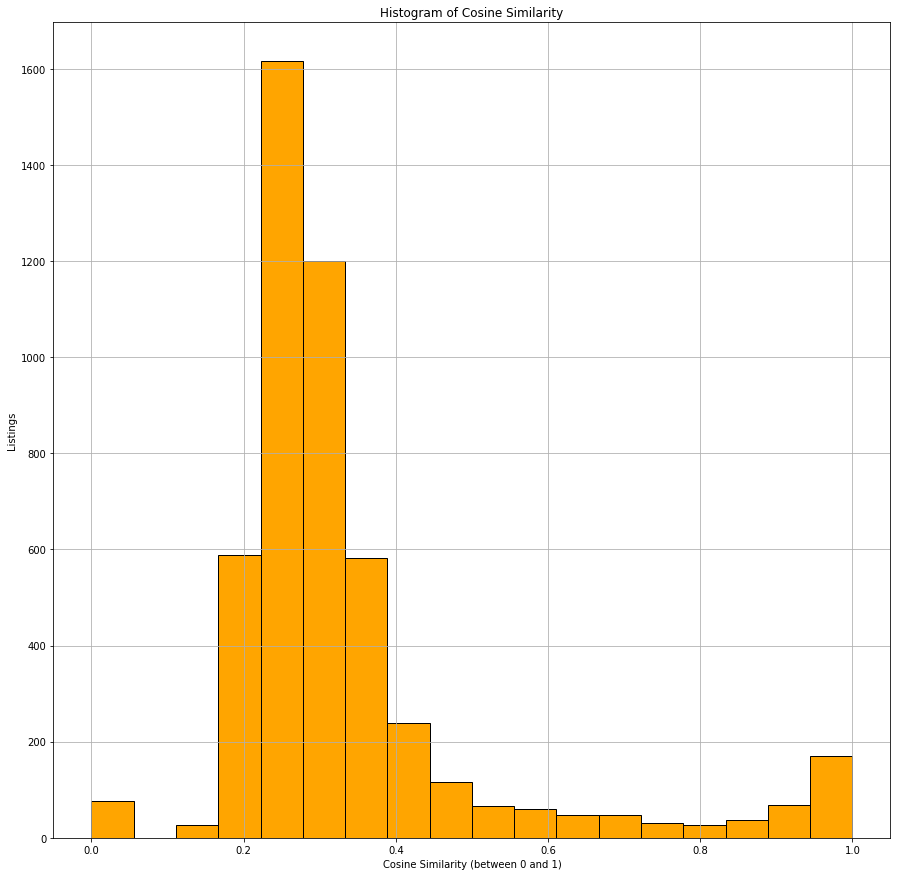

In [109]:
# Matplotlib histogram
cosine_comparison_df.hist(color = 'orange', 
                          edgecolor = 'black',
                          bins = int(180/10),
                          figsize = (15,15),
                          column = 'cosine_similarity')

# Add title and labels
plt.title('Histogram of Cosine Similarity')
plt.xlabel('Cosine Similarity (between 0 and 1)')
plt.ylabel('Listings')

# 2.3. ML for NLP: Linear Regression

We are now ready to move into machine learning. Although NLP mostly uses classification algorithms, we will start with an example in linear regression. Why? Because linear regression is very good for explaining the basic principles of machine learning.

The most simple form of linear regression assumes one input variable X that is mapped to an output varible Y. The idea is to find some kind of linear relationship between the two variables. The assumption is that a change in X will result in a change in Y in such a way, that the relationship can be mapped somehow. 

Let's imagine that we have ten rows of data with two columns, one for X and one for Y. The rows are the blue dots on the image below and that we want to draw a line that captures this relationship. We cannot hit every blue marker with our line, but will try to get as close to each marker as possible.

This is known as a least-squared solution, because we are trying to minimize the value between each blue dot and the blue line. 

![OLS](../img/ols.png)


Let's now imagine a similar scenario, but instead of just one X, we have X1 and X2. In this case the optimal solution would look something like the image below. This is basically what is meant by **optimization**. Because we draw the line (or plane, if we have more two X columns), we can now also **predict** future values of Y if we know the associated value X. If our prediction is poor, we will simply readjust the line. Hence we our model is learning, it is doing **machine learning**.

![multivariate](../img/multivariate_linear.png)

With these lessons in mind, let's now choose our Y value and X values we use to predict our Y. For our Y, we choose the price of the listings in our data. The prices of the listings are strings in our data, so we use regular expressions to extract the number in each of them and 'float()' to make that string numeric.

We then run .describe() to get some **summary statistics** of Y as well as some features or predictors that could be of interest. Feature, predictor and covariate are all names for the same thing: columns of X's that are supposed to explain or predict our Y value. We can also speak of our dependent variable (Y) and our independent variables (Xs). This language implies that we would know anything about causality between variables, but making any real statement about causality is actually very difficult.

In [110]:
# Make listing price numeric instead of string
airbnb_data['price_float'] = [float(re.findall(r'\d+',price_str)[0])
                              for price_str in airbnb_data['price']]

# Get summary statistics for some columns, including price_float which will be our 'Y' value
airbnb_data[['price_float', 'availability_30', 'bedrooms', 'bathrooms', 'number_of_reviews',
            'review_scores_rating']].describe()


price_float  availability_30     bedrooms   bathrooms  \
count   5000.00000       5000.00000  4995.000000  4998.00000   
mean     139.59800          5.83980     1.173574     1.15026   
std      110.33617          9.25404     0.743751     0.43179   
min        1.00000          0.00000     0.000000     0.00000   
25%       68.00000          0.00000     1.000000     1.00000   
50%      107.00000          0.00000     1.000000     1.00000   
75%      175.00000          8.00000     1.000000     1.00000   
max      999.00000         30.00000     8.000000     8.50000   

       number_of_reviews  review_scores_rating  
count        5000.000000           3867.000000  
mean           23.401400             93.772175  
std            44.753874              8.838938  
min             0.000000             20.000000  
25%             1.000000             91.000000  
50%             5.000000             96.000000  
75%            24.000000            100.000000  
max           596.000000            100.000000

Looks like our data is quite complete overall, but 'review_scores_rating' has a lot of missing values. Might be a bad idea to use it in the model. We can return to this table later when we are evaluating how our linear regression model did.

Okay, now let's also add some dummy variables to our model. Let's use 'host_response_time', which has four different categories, as well as 'neighbourhood_group_cleansed', which just includes all New York boroughs. Remember, by dummy variable we meant variables that aren't numbers, so we change them into columns with 1 if the listing corresponded to that category and 0 if it didn't.

In [111]:
# Add dummy variables for all values in the column 'host_response_time'
airbnb_data = pd.concat([airbnb_data, pd.get_dummies(airbnb_data['host_response_time'])], axis = 1)

# Add dummy variables for all values in the column 'neighbourhood_group_cleansed'
airbnb_data = pd.concat([airbnb_data, pd.get_dummies(airbnb_data['neighbourhood_group_cleansed'])], axis = 1)

# Replace any whitespace in the dummy variables with an underscore, as sklearn doesn't know how to read
# whitespaces in column names.
airbnb_data.columns = [column.replace(" ", "_") for column in airbnb_data.columns]

Let's see what we got by printing the length of the columns and the head of our dummies.

In [117]:
print(len(list(airbnb_data.columns)))
print(airbnb_data.iloc[:, 113:].shape)
airbnb_data.iloc[:, 113:].head()

122
(5000, 9)


a_few_days_or_more  within_a_day  within_a_few_hours  \
id                                                               
24824868                   0             0                   1   
820953                     0             0                   1   
24834739                   0             0                   0   
3666709                    0             1                   0   
19227560                   0             0                   0   

          within_an_hour  Bronx  Brooklyn  Manhattan  Queens  Staten_Island  
id                                                                           
24824868               0      1         0          0       0              0  
820953                 0      0         1          0       0              0  
24834739               1      0         1          0       0              0  
3666709                0      0         0          1       0              0  
19227560               1      0         0          0       1              0

Okay, the dummy variables look correct, because both 'host_response_time' and 'neighbourhood_group_cleansed' are both zero for all columns except one each for each row.

Now we can move to actually **fitting** this data to our linear model. When doing machine learning, this means that we need to **split** our data into a **testing** and a **training** set (often a validation set is also used). The idea here is that we fit our model to the training set and then evaluate how well it did by predicting values in the test set.


![test_train_split](../img/test_train_split.png)


Okay, so let's do this. Our Y is price. Our X is a dataframe of all the columns we wanted to use to predict Y. We then use the sklearn function 'train_test_split' to split both X and Y into a training and a testing set. The variable 'test_size' defines what share of the data will be used for testing.

We then **fit** the mode. This means that we have a hypothesis that X can be mapped to Y using linear regression. We try to fit the data of X to the linear regression algorithm, minimizing the square of the error between each point and the line that we are fitting. Once this is done, we get **coefficients** of how much each variable affects Y. Finally we predict the Ys in our test set by combining the coefficients we got from fitting our training data with the X values in our test set.

In [121]:
# Make y
y = airbnb_data['price_float']

# make X
X = pd.concat([airbnb_data.iloc[:, 113:],
        airbnb_data[['availability_30', 'bedrooms', 'bathrooms', 
         'number_of_reviews','review_scores_rating']]], axis=1).replace(np.NaN, 0)

# Split both X and Y intro training and test sets (so 4 in total)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Fit the model to get an estimate of how X relates to Y 
regressor = LinearRegression().fit(X_train, y_train)

# Use your estimate to predict the Ys in the test data based on thre Xs in the test data
y_pred = regressor.predict(X_test)

# Make a dataframe comparing your predictions for y_test and the actual y_test
actual_vs_predicted = pd.DataFrame({'Actual': y_test, 
                                    'Predicted': y_pred})  
actual_vs_predicted[:10]

Actual  Predicted
id                         
33133321   2.000    486.549
19814560  48.000     63.623
30941095  70.000     61.059
33050440 299.000    220.982
28002981 200.000    213.535
17465199 123.000    105.623
21678771 100.000    114.184
3677995  350.000    229.819
1956726  146.000    153.060
28732998 300.000    167.792

Okay, many values are off. Let's get an overall picture by getting the mean errors. These are

1) the Mean Absolute Error (MAE): Tells us what the mean error was between lines and point. This measure is inaccurate as some errors will be positive and others negative, making the mean value smaller than it should be.

2) the Mean Squared Error (MSE): This measurment squares the absolute error in order to solve the issue of negative error terms. Not very useful, because the squared value is very large and hard to interpret.

3 the Root Mean Squared Error (RMSE): For this value we take the square root of the MSE and get a value that actually reflects the mean error! **best choice**

In [122]:
# Print all error terms
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 63.173330410386356
Mean Squared Error: 8915.195711528768
Root Mean Squared Error: 94.42031408298094


Our RMSE is quite big. Let's anyway chekc out what the coefficients for each variable were. Looking at the output of the cell below, we see that the average price of each listing was, according to the model about USD 14. Pretty low, and surely wrong. OTherwise it seems that the coefficients largely make sense, but clearly they still produced a fairly inaccurate result. 

In [146]:
# Display decimals instead of scientific numbers
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Make a dataframe that includes all coefficients as well as the intercept
coeff_df = pd.DataFrame(np.append(regressor.intercept_, regressor.coef_), 
                        np.append('intercept', X.columns), columns=['Coefficient'])
coeff_df 

Coefficient
intercept                  14.228
a_few_days_or_more         -4.348
within_a_day                6.026
within_a_few_hours          9.188
within_an_hour             10.667
Bronx                     -23.887
Brooklyn                    4.057
Manhattan                  73.197
Queens                    -19.906
Staten_Island             -33.461
availability_30             1.175
bedrooms                   51.637
bathrooms                  22.131
number_of_reviews          -0.121
review_scores_rating       -0.041

In sum, it seems like our predictions are quite a bit off. This isn't unusual. First of all, our variables weren't that interesting. For example, I tried to make all NY neighbourhoods (instead of just boroughs) into dummies, and that model did much better. Secondly, linear regression just isn't that good of a model. It is rigid and unable to accurately represent complex relations in complex datasets.